# Preprocessing and data set creation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from astropy.io import fits
from TNGDataSet import TNGDataSet
plt.style.use(astropy_mpl_style)
import jax
import jax.numpy as jnp
import transformations.transformations as _transformations

2023-07-05 22:57:31.541527: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 22:57:32.507729: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Dummy scaling function
def ScaleImage(img, z = 0.1, experiment = 'HSC', new_size = 150):

    rescaled_image = _transformations.get_downscaled_image_at_z_in_janski(
        image_data = img, 
        z = z, 
        experiment = experiment, 
        use_zoom_func = True   
    )

    return tf.image.resize_with_crop_or_pad(rescaled_image[:,:,None], new_size, new_size)[:,:,0].numpy()

## Tracing function
set to 0 for no traces up to 4 for alot of traces

In [3]:
os.environ["DIFF_TRACE"]="0"

## Set up dataset creation arguments and load the data set

Dataset is only loaded the first time and will be stored locally in data_dir/tng_data_set folder
If you wish to reload you need to delete this folder and relanch this cell

In [4]:
arg_dict = {
    'train_percent':0.00001,
    'val_percent':0.00001, 
    'test_percent':0.00001 , 
    'generation_verbosity' : 10 , 
    'Scaler_fcn':ScaleImage,
    'band_filters' : ['CFHT_MEGACAM.U', 'SUBARU_HSC.G' ,'SUBARU_HSC.R' ,'CFHT_MEGACAM.R' ,'SUBARU_HSC.I', 'SUBARU_HSC.Z' ,'SUBARU_HSC.Y']
    }
#subsets = [tfds.Split.TRAIN,tfds.Split.VALIDATION, tfds.Split.TEST]
subsets = [tfds.Split.TRAIN,tfds.Split.VALIDATION]
ds = tfds.load('TNGDataSet', split=subsets, data_dir="/scratch/astroinfo2023/diffusion/", builder_kwargs=arg_dict)

2023-07-05 22:57:35.609949: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


To recover the subsets you can recover them directly from the newly created dataset

In [5]:
train_dataset, validation_dataset = ds

In [6]:
train_dataset

<_PrefetchDataset element_spec={'BUNIT': TensorSpec(shape=(), dtype=tf.string, name=None), 'CAMERA': TensorSpec(shape=(), dtype=tf.string, name=None), 'EXTNAME': TensorSpec(shape=(), dtype=tf.string, name=None), 'FILTER': TensorSpec(shape=(), dtype=tf.string, name=None), 'FOVSIZE': TensorSpec(shape=(), dtype=tf.float32, name=None), 'NAXIS1': TensorSpec(shape=(), dtype=tf.int32, name=None), 'NAXIS2': TensorSpec(shape=(), dtype=tf.int32, name=None), 'ORIGIN': TensorSpec(shape=(), dtype=tf.string, name=None), 'REDSHIFT': TensorSpec(shape=(), dtype=tf.float32, name=None), 'SIMTAG': TensorSpec(shape=(), dtype=tf.string, name=None), 'SNAPNUM': TensorSpec(shape=(), dtype=tf.int32, name=None), 'SUBHALO': TensorSpec(shape=(), dtype=tf.int32, name=None), 'img': TensorSpec(shape=(150, 150), dtype=tf.float32, name=None)}>

In [7]:
# Training set preparation
def load_dataset(batch_size, noise_dist_std):

  def pre_process(im):
    """ Pre-processing function preparing data for denoising task
    """
    # Cutout a portion of the map
    x = tf.image.resize_with_crop_or_pad(im['img'][..., tf.newaxis], 128, 128)
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    # Sample random Gaussian noise
    u = tf.random.normal(tf.shape(x))
    # Sample standard deviation of noise corruption
    s = noise_dist_std * tf.random.normal((1, 1, 1))
    # Create noisy image
    y = x + s * u
    return {'x':x, 'y':y, 'u':u,'s':s}

  ds = train_dataset
  ds = ds.shuffle(buffer_size=10*batch_size)
  ds = ds.repeat()
  ds = ds.map(pre_process)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds.as_numpy_iterator()

In [32]:
cosmos_dset = load_dataset(32, .000000025)
batch = next(cosmos_dset)

2023-07-05 22:59:54.381932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-07-05 22:59:54.382795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


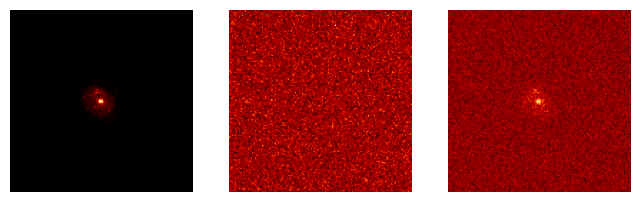

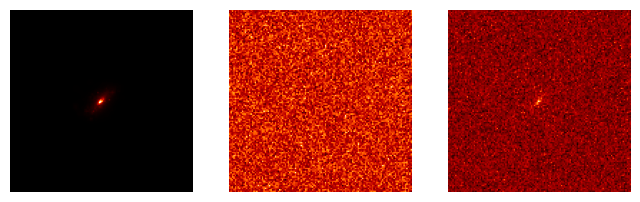

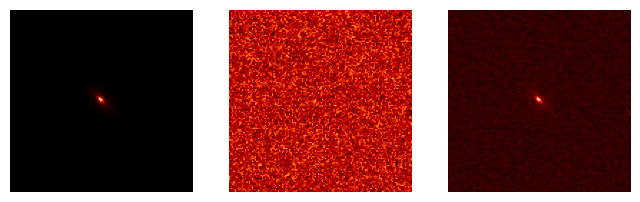

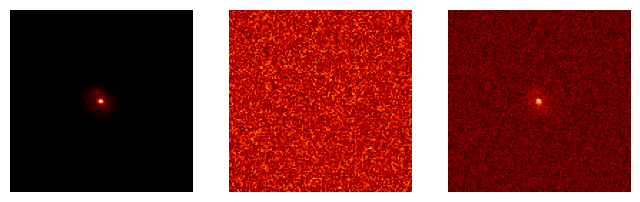

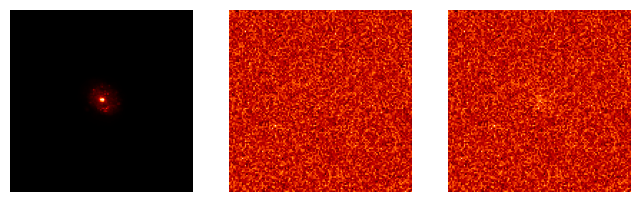

In [50]:
%pylab inline
for i in range(5):
    figure()
    subplot(131)
    imshow(batch['x'][i])
    axis('off')
    subplot(132)
    imshow(batch['u'][i])
    axis('off')
    subplot(133)
    imshow(batch['y'][i])
    axis('off')


In [34]:
## np.shape(batch['x'])

In [35]:
np.shape(batch['y'][i])

(128, 128, 1)

In [36]:
# Ok, so now we just need to train 
from models import SmallUResNet
from normalization import SNParamsTree
import haiku as hk
import optax

In [37]:
model = hk.transform_with_state(lambda x, sigma, is_training=False: SmallUResNet()(x, sigma, is_training))

In [38]:
params, state = model.init(jax.random.PRNGKey(0), jnp.zeros([1,128,128,1]), jnp.zeros([1,1,1,1]), is_training=True)

In [39]:
def lr_schedule(step):
  """Linear scaling rule optimized for 90 epochs."""
  steps_per_epoch = 40000 // 32

  current_epoch = step / steps_per_epoch  # type: float
  lr = (1.0 * 32) / 32
  boundaries = jnp.array((20, 40, 60)) * steps_per_epoch
  values = jnp.array([1., 0.1, 0.01, 0.001]) * lr

  index = jnp.sum(boundaries < step)
  return jnp.take(values, index)

In [40]:
optimizer = optax.chain(
  optax.adam(learning_rate=1e-3),
  optax.scale_by_schedule(lr_schedule)
)
rng_seq = hk.PRNGSequence(42)

In [41]:
sn_fn = hk.transform_with_state(lambda x: SNParamsTree(ignore_regex='[^?!.]*b', val=1.)(x))

In [42]:
_, sn_state = sn_fn.init(next(rng_seq), params)

In [43]:
params, sn_state = sn_fn.apply(None, sn_state, None, params)

In [44]:
opt_state = optimizer.init(params)

In [45]:
def loss_fn(params, state, rng_key, batch):
    score, state = model.apply(params, state, rng_key, batch['y'], batch['s'], is_training=True)
    loss = jnp.mean((batch['u'] + batch['s'] * (score))**2)
    return loss, state

In [46]:
@jax.jit
def update(params, state, sn_state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    new_params, new_sn_state = sn_fn.apply(None, sn_state, None, new_params)
    return loss, new_params, state, new_sn_state, new_opt_state

In [47]:
from flax.metrics import tensorboard
import pickle

In [48]:
summary_writer = tensorboard.SummaryWriter('models/score_model_0.025')

In [49]:
for step in range(10000):
    print(step)
    loss, params, state, sn_state, opt_state = update(params, state, sn_state,
                                                      next(rng_seq), opt_state,
                                                      next(cosmos_dset))
    summary_writer.scalar('train_loss', loss, step)
    summary_writer.scalar('learning_rate', lr_schedule(step)*1e-3, step)
    
    if step%5000 ==0:
        with open('models/score_model_0.025/model-%d.pckl'%step, 'wb') as file:
            pickle.dump([params, state, sn_state], file)

0
1


Exception ignored in: <function _xla_gc_callback at 0x2aab23d63ba0>
Traceback (most recent call last):
  File "/home/astroinfo2023/micromamba/envs/diffhack/lib/python3.11/site-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


2
3
4


KeyboardInterrupt: 

In [ ]:
def score_fn(y, s):
    score, _ = model.apply(params, state, None, y, s.reshape((-1,1,1,1)), is_training=False)
    return score

In [ ]:
score = score_fn(batch['y'], batch['s'])
     

In [ ]:
for i in range(16):
    figure(figsize=[20,5])
    subplot(141)
    imshow(batch['x'][i])
    axis('off')
    subplot(142)
    imshow(batch['y'][i])
    axis('off')
    subplot(143)
    imshow(score[i])
    axis('off')
    subplot(144)
    imshow(batch['y'][i] + (batch['s']**2 * score)[i])
    axis('off')